In [ ]:
import sys
import warnings
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

sys.path.append('..')

from score_with_all_methods import (
    score_signatures_with_all_methods,
    label_assignment_from_scores,
    get_lbl_assignment_performance,
    get_information_from_scores,
    remove_overlapping_signature_genes,
    get_violin_all_methods,
    prepare_data_for_violin_plot,
    save_close_or_show,
    plot_confusion_matrix
)

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'pdf.fonttype': 42, 'font.family': 'sans-serif', 'font.sans-serif': 'Arial', 'font.size': 10})

# Ovarian cancer dataset
Vázquez-García, I., Uhlitz, F., Ceglia, N. et al. Ovarian cancer mutational processes drive site-specific immune evasion. Nature 612, 778–786 (2022). https://doi.org/10.1038/s41586-022-05496-1

Storing information and global variables

In [ ]:
data_path = Path('/Users/lciernik/Documents/TUB/projects/ans_scoring/data')
remove_overlapping_genes = True

SAVE = False
storing_path = Path('/Users/lciernik/Documents/TUB/projects/ans_scoring/results/cancer_datasets/ovarian')

if remove_overlapping_genes:
    storing_path = storing_path / 'signatures_without_overlapping'
else:
    storing_path = storing_path / 'signatures_with_overlapping'

if SAVE:
    storing_path.mkdir(parents=True, exist_ok=True)

Loading data

In [ ]:
def preprocess(adata):
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], log1p=True, inplace=True)
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_genes(adata, min_cells=3)
    # sc.pp.scrublet(adata, batch_key="patient")
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    return adata

In [ ]:
adata = sc.read_h5ad(data_path / 'raw_data/ovarian_malignant.h5ad')
adata = preprocess(adata)

In [ ]:
adata.obs['cluster_label'].value_counts(dropna=False).sort_index()

In [ ]:
adata.shape

In [ ]:
y_true_col = 'cluster_label'
sample_col = 'patient_id'

In [ ]:
adata.obs[y_true_col].value_counts().sort_index()

Loading signatures

In [ ]:
signatures = pd.read_csv(data_path / "annotations/cancer/ovarian_vazquez/ovarian_states.csv")

In [ ]:
signatures = signatures.to_dict('series')
signatures = {k: sorted(v.dropna().tolist()) for k, v in signatures.items()}

In [ ]:
if remove_overlapping_genes:
    signatures = remove_overlapping_signature_genes(signatures)

In [ ]:
order_signatures = list(signatures.keys())
order_signatures

Computing dimensionality reduction

In [ ]:
# sc.tl.pca(adata)
# sce.pp.harmony_integrate(adata, sample_col)
# sc.pp.neighbors(adata, use_rep='X_pca_harmony')
# sc.tl.umap(adata)

Scoring signatures

In [ ]:
score_cols, adata = score_signatures_with_all_methods(adata, signatures)

Label assignment

In [ ]:
all_cols = []
label_cols = {}
for method_name, method_scores in score_cols.items():
    adata, new_lbl_col = label_assignment_from_scores(adata, method_name, method_scores, include_undefined=False)
    label_cols[method_name] = new_lbl_col
    all_cols += method_scores + [new_lbl_col]

Visualizing results

In [ ]:
# fig = sc.pl.umap(adata, color=all_cols + [sample_col, y_true_col], ncols=len(signatures) + 1, return_fig=True)
# if SAVE:
#     fig.savefig(storing_path / 'umap.png', bbox_inches='tight')
#     fig.savefig(storing_path / 'umap.pdf', bbox_inches='tight')
#     plt.close(fig)
#     print(f"Saved UMAP.")
# else:
#     plt.show(fig)

In [ ]:
df_melted = prepare_data_for_violin_plot(adata, y_true_col, score_cols)

In [ ]:
### Combined violin plots
fig = get_violin_all_methods(df_melted, 
                             y_true_col, 
                             hue_order=order_signatures, 
                             textwrap_width=7, 
                             height=2, aspect=3, 
                             sharey=False,
                             col_wrap=2,
                             legend_bbox_anchor=(1, 1),
                             fontsizes={'title': 12, 'labels': 10, 'ticks': 10, 'legend': 10})
save_close_or_show(fig, SAVE, storing_path / "violin_all_methods.pdf")

In [ ]:
# for method_name, method_scores in score_cols.items():
#     df = adata.obs.loc[:, method_scores + [y_true_col]]
#     fig = get_violin(df, method_scores, y_true_col)
#     plt.title(f"{method_name}")
#     if SAVE:
#         fig.savefig(storing_path / f'violin_{method_name}.png', bbox_inches='tight')
#         fig.savefig(storing_path / f'violin_{method_name}.pdf', bbox_inches='tight')
#         plt.close(fig)
#         print(f"Saved violin plot for {method_name}.")
#     else:
#         plt.show(fig)

Computing label assignment performance

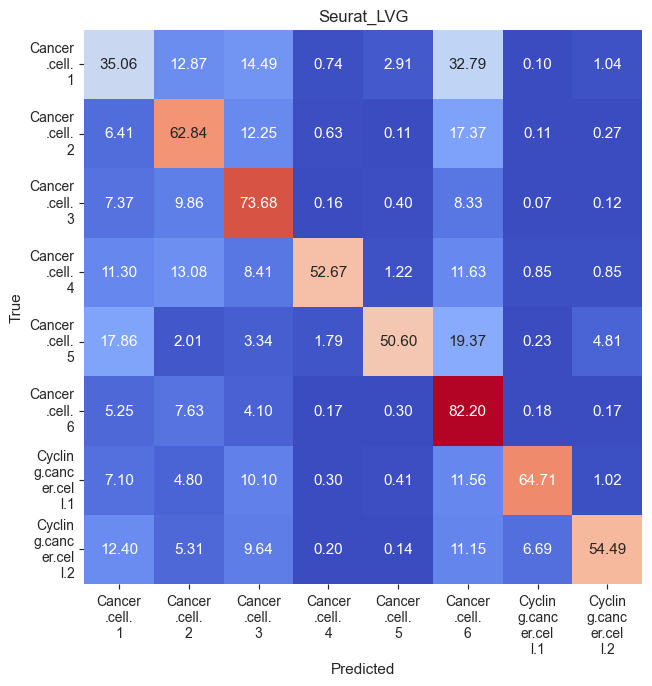

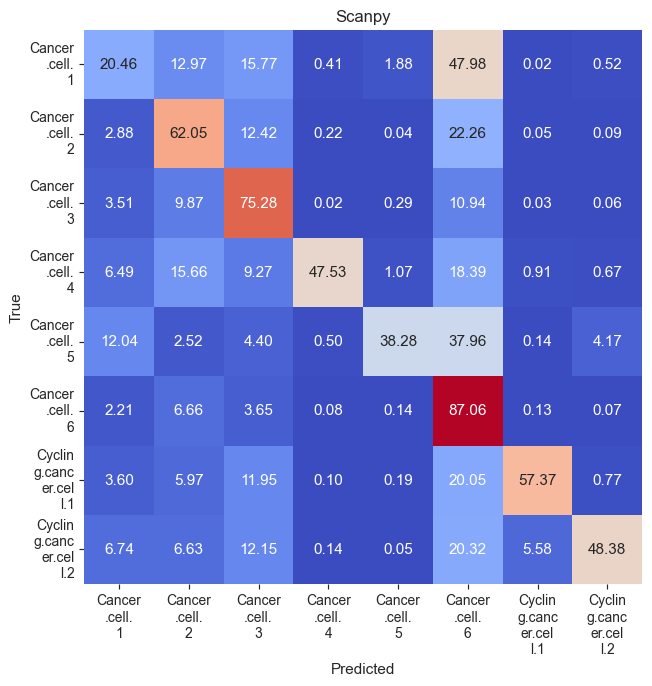

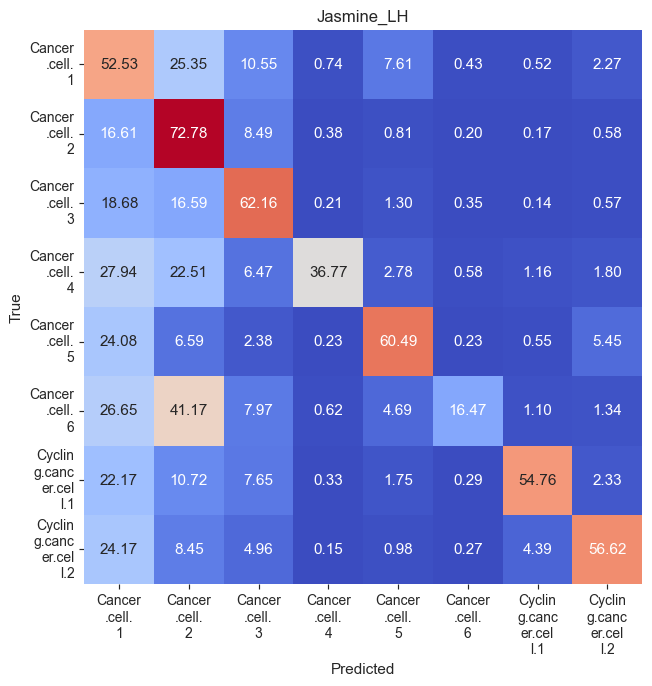

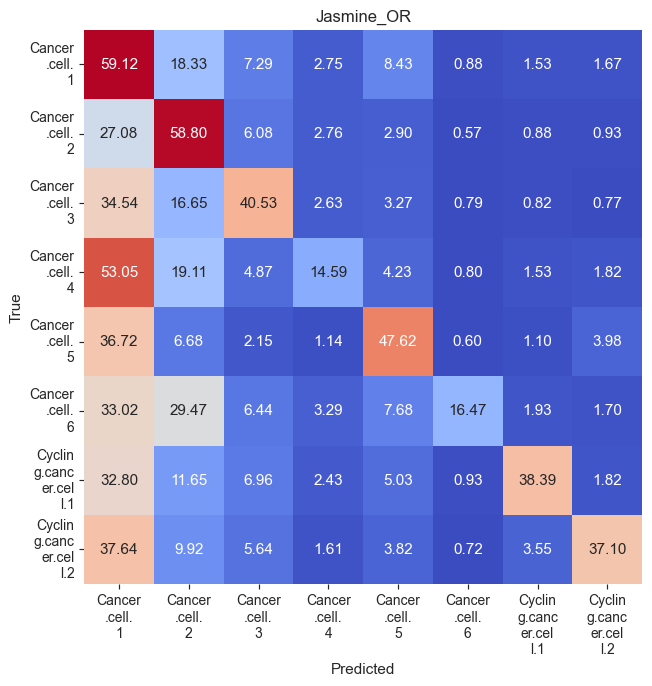

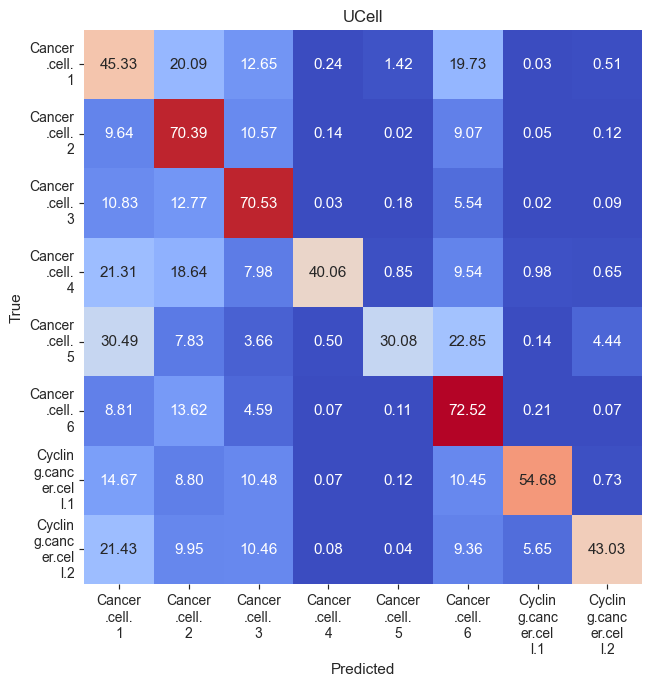

In [23]:
metrics = defaultdict(dict)
nfold = 10

for method_name, method_scores in score_cols.items():
    lbl_col = label_cols[method_name]
    conf_mat, bal_acc, f1_val = get_lbl_assignment_performance(adata,
                                                               y_true_col=y_true_col,
                                                               y_pred_col=lbl_col,
                                                               label_names=order_signatures)

    scores = get_information_from_scores(adata, y_true_col=y_true_col, scores=method_scores, nfold=nfold)

    metrics[method_name] = {
        'conf_mat': conf_mat,
        'balanced_accuracy': bal_acc,
        'f1_score': f1_val,
        f'logreg_balanced_accuracy_{nfold}cv': np.mean(scores),
        f'logreg_balanced_accuracy_{nfold}cv_std': np.std(scores)
    }

    ## Confusion matrix plot
    # fig = plot_confusion_matrix(conf_mat, order_signatures, method_name, figsize=(4, 4), textwrap_width=7,
    #                             xrotation=45, cbar=False)
    fig = plot_confusion_matrix(conf_mat, order_signatures, method_name, textwrap_width=6)
    save_close_or_show(fig, SAVE, storing_path / f'conf_mat_{method_name}.pdf')

In [ ]:
metrics_df = pd.DataFrame(metrics)

Saving performance metrics

In [ ]:
if SAVE:
    metrics_df.to_csv(storing_path / 'metrics.csv')
    print(f"Saved metrics to {storing_path / 'metrics.csv'}.")